In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os, random
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from scipy.signal import savgol_filter
from scipy import interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
np.random.seed( 0 )
sns.set_style( "darkgrid" )

## Preprocessing/Cleaning

In [121]:
df = pd.read_parquet("C:\\Users\\lselig\\selig-fa\\finance\\.data\\ratios.parquet")
df["year"] = pd.DatetimeIndex(df["date"]).year
df = df[df.year == 2022]
print(df.shape)
print(df.describe())
print(list(df))
print(df.isna().sum())

# lots of missing values, these columns are missing most frequently (> 100k / 350k)
worst_offenders = ["totalDebtToCapitalization", "interestCoverage", "inventoryTurnover", "cashFlowCoverageRatios", "shortTermCoverageRatios",
                   "dividendPaidAndCapexCoverageRatio", "dividendPayoutRatio", "dividendYield"]

df.drop(columns = worst_offenders, inplace = True)
print(df.shape)

df.dropna(inplace = True)
print(df.shape)


qualitative_cols = ["symbol", "date", "period", "year"]
qualitatives = df[qualitative_cols]
df.drop(columns = qualitative_cols, inplace = True)
print(df.shape)


(20873, 58)
        currentRatio    quickRatio     cashRatio  daysOfSalesOutstanding  \
count   19241.000000  1.924100e+04  1.924100e+04            1.884800e+04   
mean       56.837099  2.204870e+03  8.462447e+01            2.978581e+12   
std      3886.378521  2.907768e+05  8.632393e+03            3.627654e+14   
min         0.000000  0.000000e+00 -7.860085e-03           -6.875094e+05   
25%         1.072166  7.078762e-01  2.314576e-01            1.055985e+02   
50%         1.898114  1.391059e+00  6.444836e-01            2.055429e+02   
75%         3.962758  3.279770e+00  1.786494e+00            3.275911e+02   
max    524182.848297  4.032705e+07  1.175238e+06            4.964380e+16   

       daysOfInventoryOutstanding  operatingCycle  daysOfPayablesOutstanding  \
count                1.507200e+04    1.492500e+04               1.507200e+04   
mean                 1.052198e+12    1.153752e+12               2.835254e+14   
std                  1.291721e+14    1.317033e+14              

In [122]:
features = df.to_numpy()
# features = df
scaler = StandardScaler()
features =  scaler.fit_transform(features)
features = np.clip(features, -5, 5)
print(features.shape)
n_features = features.shape[1]
print(n_features)
%matplotlib widget 
for i in range(n_features):
    print(i, np.nanmin(features[:, i]), np.nanmax(features[:, i]))
    sns.kdeplot(features[:, i])
plt.title("Distribution of final features")
plt.close()

(9924, 46)
46
0 -0.6563837279975262 5.0
1 -0.010552826020360336 5.0
2 -0.4821139885597377 5.0
3 -0.01408020988934935 5.0
4 -0.010038723873611856 5.0
5 -0.01013602985287706 5.0
6 -0.01018558383424663 5.0
7 -0.010126006252579624 5.0
8 -5.0 5.0
9 -5.0 0.010059337331851874
10 -5.0 0.01005922478259755
11 -5.0 0.010055096537276967
12 -5.0 5.0
13 -5.0 5.0
14 -5.0 5.0
15 -5.0 5.0
16 -5.0 5.0
17 -5.0 5.0
18 -5.0 0.010059337331851874
19 -1.1156984791049618 5.0
20 -5.0 5.0
21 -5.0 5.0
22 -0.30900873353391656 5.0
23 -5.0 5.0
24 -0.2600134112301827 5.0
25 -0.011335472081253128 5.0
26 -0.15852186452077655 5.0
27 -0.30133732593694773 5.0
28 -5.0 5.0
29 -5.0 5.0
30 -0.015172275768555123 5.0
31 -5.0 5.0
32 -5.0 0.010177448947585105
33 -5.0 5.0
34 -5.0 5.0
35 -0.040165619900500785 5.0
36 -0.040165619900500785 5.0
37 -0.010046152029352294 5.0
38 -5.0 0.3591043345974471
39 -5.0 5.0
40 -5.0 5.0
41 -5.0 5.0
42 -5.0 5.0
43 -0.010046152029352294 5.0
44 -1.00222707838247 5.0
45 -0.040165619900500785 5.0


                                    currentRatio  quickRatio  cashRatio  \
currentRatio                            1.000000   -0.002005   0.812750   
quickRatio                             -0.002005    1.000000  -0.003945   
cashRatio                               0.812750   -0.003945   1.000000   
daysOfSalesOutstanding                  0.030036   -0.000110   0.027575   
daysOfInventoryOutstanding              0.009307   -0.000091   0.021742   
operatingCycle                          0.009669   -0.000092   0.021906   
daysOfPayablesOutstanding               0.009855   -0.000092   0.021989   
cashConversionCycle                     0.009624   -0.000092   0.021885   
grossProfitMargin                      -0.007553    0.000121  -0.010438   
operatingProfitMargin                  -0.009383    0.000091  -0.021777   
pretaxProfitMargin                     -0.009383    0.000091  -0.021776   
netProfitMargin                        -0.009368    0.000091  -0.021769   
effectiveTaxRate         

<AxesSubplot:>

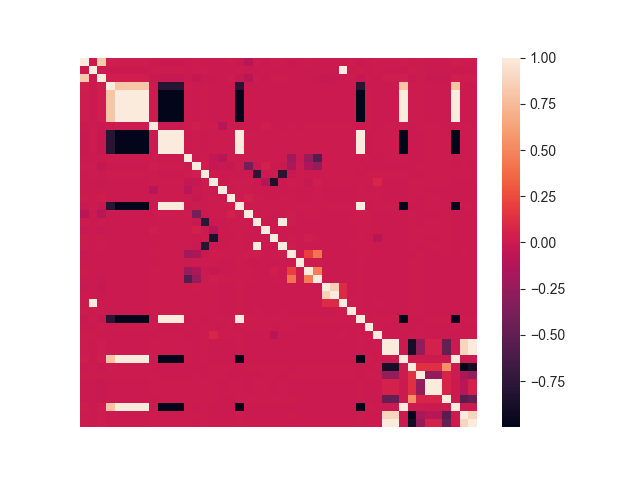

In [123]:
corr = df.corr()
print(corr)
sns.heatmap(corr, annot = False, xticklabels= False, yticklabels=False)


In [124]:
print(features.shape)
pca = PCA(n_components=2)
pca.fit(features.T)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
components = pca.components_.T
print(components.shape)
# plt.close()
# plt.hist2d(components[:, 0], components[:, 1], bins = 100)
# plt.show()

(9924, 46)
[0.35651652 0.12139852]
0.4779150346294025
(9924, 2)


# Goal: Use clustering to identify potential outliers based on financial ratios

[23 24 25 26]
[5893 5894 5895 5896]
[3862 3863 3864 3865]
[6399 6400 6401 6402]
(9924, 3)


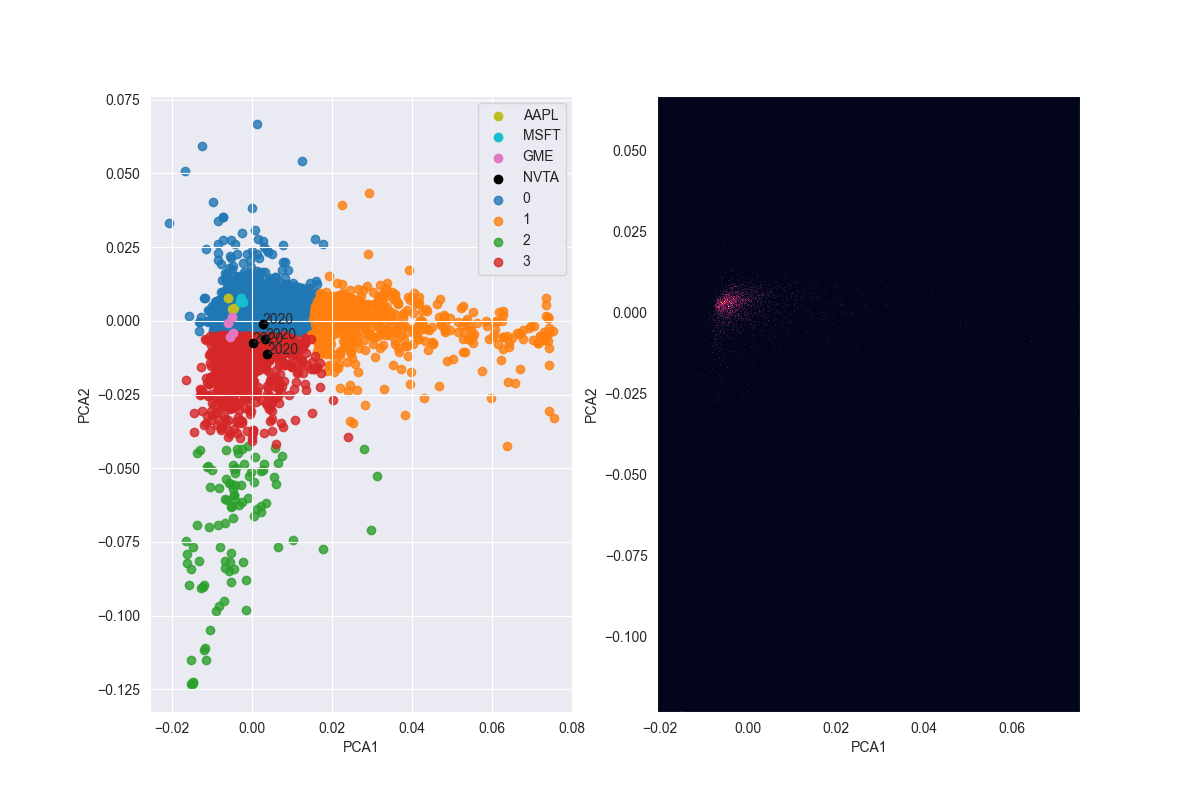

In [125]:
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation

# winners = ["AAPL", "MSFT", "GOOGL"]

clst = KMeans(n_clusters=4, random_state=0).fit(components)
# clst = AffinityPropagation( random_state=0).fit(components)
labels = clst.labels_.reshape(-1, 1)
# print(qualitatives)
tickers = qualitatives.symbol.values
fig, axs = plt.subplots(1, 2, figsize = (12, 8))
pca_and_labels = np.hstack((components, labels))

def overlay_specific_stock(ticker, ax, color = "C8", show_date = False):
    winners_idx = np.where(tickers == ticker)[0]
    print(winners_idx)
    x = pca_and_labels[winners_idx][:, 0]
    y = pca_and_labels[winners_idx][:, 1]
    ax.scatter(x, y, label = ticker, color = color, zorder = 1)
    if(show_date):
        for idx in winners_idx:
            x = pca_and_labels[idx][0]
            y = pca_and_labels[idx][1]
            ax.text(x, y, s = qualitatives.iloc[idx].year)

# overlay_specific_stock("GOOGL", axs[0], color = "C7")
overlay_specific_stock("AAPL", axs[0], color = "C8", show_date = False)
overlay_specific_stock("MSFT", axs[0], color = "C9")
overlay_specific_stock("GME", axs[0], color = "C6")
# overlay_specific_stock("TSLA", axs[0], color = "black")
# overlay_specific_stock("GME", axs[0], color = "black", show_date = True)
# overlay_specific_stock("HIVE", axs[0], color = "black", show_date = True)
# overlay_specific_stock("BOXD", axs[0], color = "black", show_date = True)
# overlay_specific_stock("NVCN", axs[0], color = "black", show_date = True)
overlay_specific_stock("NVTA", axs[0], color = "black", show_date = True)


print(pca_and_labels.shape)
clst.labels_.shape
for g in np.unique(labels):
    idxs = np.where(pca_and_labels[:, 2] == g)[0]
    cluster = pca_and_labels[idxs]
    # print(cluster)
    # for i, c in enumerate(cluster):
    #     print(c[0], c[1], qualitatives[:, 0][idxs[i]])
    #     axs[0].text(c[0], c[1], s = qualitatives[:, 0][idxs[i]])
    axs[0].scatter(cluster[:, 0],  cluster[:, 1], label = g, alpha = 0.8, zorder = -1)
axs[0].set_xlabel("PCA1")
axs[0].set_ylabel("PCA2")
axs[1].hist2d(pca_and_labels[:, 0], pca_and_labels[:, 1], bins = 1000, zorder = -1)
axs[1].set_xlabel("PCA1")
axs[1].set_ylabel("PCA2")
axs[0].legend()
plt.show()
